# changelog

changed 'dropped' to 'cleaned'
exploring and binning weather column
exploring and binning crash month

# Cleaning

This notebook illustrates detailed download and cleaning of the Chicago Crash data. 

Our Problem focused on what factors contribute to **severe** traffic incidents at **night**. 

* **Severe** traffic incidents we defined as `FATAL` or `INCAPACITATING` from the `INJURY_TYPE` column. 

* **Night** we defined as the hours between 10pm to 5 am, or hours `22` through `5` in the `CRASH_HOUR` column. 

* Final output is `final_df` which will be used in the following notebook(s).

### Loading the Neccessary Packages and CSV Files

In [1]:
#Importing the neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
crash_df = pd.read_csv('data/Traffic_Crashes_-_crashes.csv')
people_df = pd.read_csv('data/Traffic_Crashes_-_people.csv', low_memory=False)
vehicle_df = pd.read_csv('data/Traffic_Crashes_-_vehicles.csv', low_memory=False)

### Dropping Unneccessary Columns

#### `crash_df` dropping Justification: 

* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept `CRASH_RECORD_ID` as the joining record number for each dataframe. 
* `CRASH_DATE_EST_I` - used when crash is reported to police days after the crash, this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `CRASH_DATE` - this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `REPORT_TYPE` - administrative report type, not a factor relevant to causing a crash.
* `HIT_AND_RUN_I` - not a factor relevant to causing a crash.
* `DATE_POLICE_NOTIFIED` - not a factor relevant to causing a crash.
* `STREET_NO` - of location related data we chose to keep latitude, longitude
* `BEAT_OF_OCCURENCE` - not a factor relevant to causing a crash.
* `PHOTOS_TAKEN_I` - not a factor relevant to causing a crash.
* `STATEMENTS_TAKEN` - not a factor relevant to causing a crash.
* `MOST_SEVERE_INJURY` - basing our severity of injury off of information from the `people_df` dataframe, including this and other injury related columns would cause multicolliniarity in our modeling. 
* `INJURIES_FATAL`
* `INJURIES_NON_INCAPACITATING`
* `INJURIES_REPORTED_NOT_EVIDENT`
* `INJURIES_NO_INDICATION`
* `INJURIES_UNKNOWN`
* `LONGITUDE`
* `LATITUDE`

In [3]:
crash_df_cleaned = crash_df[['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                                          'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT', 
                                          'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'NOT_RIGHT_OF_WAY_I',
                                          'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
                                          'DOORING_I','WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 
                                          'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

#### `people_df` dropping Justification: 

* `PERSON_ID` - unique ID for each person record, 

... do we need to fill in reasons for all these? 

In [4]:
people_df_cleaned = people_df[['CRASH_RECORD_ID', 'PERSON_TYPE', 'AGE', 'DRIVERS_LICENSE_STATE',
                                'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT VALUE', 
                                'INJURY_CLASSIFICATION']]

#### `vehicle_df` dropping Justification: 

* `---`, 

... do we need to fill in reasons for all these? 

In [5]:
vehicle_df_dropped = vehicle_df[['CRASH_RECORD_ID', 'VEHICLE_YEAR', 'MANEUVER']]

## Subsetting crash records between 10 pm and 5 am

In [6]:
night_time_df = crash_df_cleaned.copy()
night_time_df = night_time_df[(night_time_df['CRASH_HOUR'] >= 22) | (night_time_df['CRASH_HOUR'] <= 6)]
night_time_df.columns

Index(['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'NOT_RIGHT_OF_WAY_I',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'DOORING_I',
       'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

## Joining all three data sets

In [7]:
#checking the shape
night_time_df.shape, people_df_cleaned.shape

((93448, 18), (1224613, 8))

In [8]:
merge1 = pd.merge(night_time_df, people_df_cleaned, how='left', on='CRASH_RECORD_ID')
merge1.shape

(188733, 25)

## Further Exploring Columns

#### `INJURY_CLASSIFICATION` target Variable - this includes all people involved in incident, cyclists, passengers, drivers, etc. 

In [9]:
merge1['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     166735
NONINCAPACITATING INJURY     12730
REPORTED, NOT EVIDENT         5501
INCAPACITATING INJURY         2834
FATAL                          310
Name: INJURY_CLASSIFICATION, dtype: int64

In [10]:
# fatal / incapacitate = 1
merge1.loc[(merge1['INJURY_CLASSIFICATION'] == 'FATAL') | 
           (merge1['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY'), 'INJURY_CLASSIFICATION'] = '1'

# else = 0
merge1.loc[merge1['INJURY_CLASSIFICATION'] != '1', 'INJURY_CLASSIFICATION'] = '0'

merge1['INJURY_CLASSIFICATION'].fillna('0', inplace=True)

In [11]:
merge1["INJURY_CLASSIFICATION"].value_counts(normalize=True)

0    0.983342
1    0.016658
Name: INJURY_CLASSIFICATION, dtype: float64

### change2 start

In [12]:
merge1['WEATHER_CONDITION'].value_counts()

CLEAR                     146655
RAIN                       21140
UNKNOWN                     8715
SNOW                        7102
CLOUDY/OVERCAST             2739
OTHER                        925
FOG/SMOKE/HAZE               680
FREEZING RAIN/DRIZZLE        347
SLEET/HAIL                   337
BLOWING SNOW                  65
SEVERE CROSS WIND GATE        28
Name: WEATHER_CONDITION, dtype: int64

In [13]:
merge1['WEATHER_CONDITION'].value_counts().sum()

188733

In [14]:
merge1.shape

(188733, 25)

In [15]:
merge1['WEATHER_CONDITION'].isna().sum()

0

In [16]:
merge1['WEATHER_CONDITION'].value_counts().drop(['CLEAR']).sum()

42078

In [17]:
# put into a new columns

In [18]:
# 1 is clear
merge1.loc[merge1['WEATHER_CONDITION'] == 'CLEAR', 'WEATHER_CONDITION'] = 1

# 0 is not clear
merge1.loc[merge1['WEATHER_CONDITION'] != 1, 'WEATHER_CONDITION'] = 0

In [19]:
merge1['WEATHER_CONDITION'].value_counts(normalize=True)

1    0.77705
0    0.22295
Name: WEATHER_CONDITION, dtype: float64

In [20]:
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188733 entries, 0 to 188732
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          188733 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   188733 non-null  object 
 2   DEVICE_CONDITION         188733 non-null  object 
 3   WEATHER_CONDITION        188733 non-null  object 
 4   LIGHTING_CONDITION       188733 non-null  object 
 5   LANE_CNT                 68969 non-null   float64
 6   ROADWAY_SURFACE_COND     188733 non-null  object 
 7   ROAD_DEFECT              188733 non-null  object 
 8   NOT_RIGHT_OF_WAY_I       6792 non-null    object 
 9   PRIM_CONTRIBUTORY_CAUSE  188733 non-null  object 
 10  SEC_CONTRIBUTORY_CAUSE   188733 non-null  object 
 11  DOORING_I                388 non-null     object 
 12  WORK_ZONE_I              1105 non-null    object 
 13  WORK_ZONE_TYPE           822 non-null     object 
 14  WORK

### change2 end

### change3 start

In [21]:
merge1['CRASH_MONTH'].value_counts()

7     19659
8     18831
9     17955
6     17680
10    17354
5     15966
12    15248
1     13843
11    13711
3     13555
4     12812
2     12119
Name: CRASH_MONTH, dtype: int64

<BarContainer object of 12 artists>

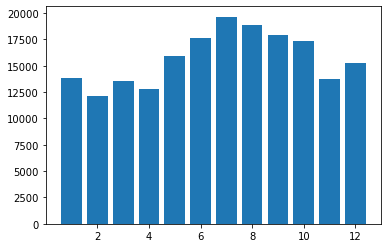

In [22]:
fig, ax = plt.subplots()

ax.bar(merge1['CRASH_MONTH'].value_counts().index, merge1['CRASH_MONTH'].value_counts())

In [23]:
# binning by four seasons

### charge3 end

In [24]:
final_df = merge1.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188733 entries, 0 to 188732
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          188733 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   188733 non-null  object 
 2   DEVICE_CONDITION         188733 non-null  object 
 3   WEATHER_CONDITION        188733 non-null  object 
 4   LIGHTING_CONDITION       188733 non-null  object 
 5   LANE_CNT                 68969 non-null   float64
 6   ROADWAY_SURFACE_COND     188733 non-null  object 
 7   ROAD_DEFECT              188733 non-null  object 
 8   NOT_RIGHT_OF_WAY_I       6792 non-null    object 
 9   PRIM_CONTRIBUTORY_CAUSE  188733 non-null  object 
 10  SEC_CONTRIBUTORY_CAUSE   188733 non-null  object 
 11  DOORING_I                388 non-null     object 
 12  WORK_ZONE_I              1105 non-null    object 
 13  WORK_ZONE_TYPE           822 non-null     object 
 14  WORK

In [25]:
final_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNABLE TO DETERMINE                                                                 64201
FAILING TO YIELD RIGHT-OF-WAY                                                       16106
FOLLOWING TOO CLOSELY                                                               16072
FAILING TO REDUCE SPEED TO AVOID CRASH                                              12682
DISREGARDING TRAFFIC SIGNALS                                                         9482
NOT APPLICABLE                                                                       8620
IMPROPER OVERTAKING/PASSING                                                          7836
IMPROPER LANE USAGE                                                                  7114
IMPROPER TURNING/NO SIGNAL                                                           6856
IMPROPER BACKING                                                                     5310
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER     4657
DRIVING SK

#### Exporting the `final_df` into csv file

In [26]:
#clean_data = final_df.to_csv('clean_data.csv', index = False)

In [27]:
from sklearn.model_selection import train_test_split

#X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
X = final_df[['CRASH_HOUR', 'CRASH_MONTH']]
y = final_df['INJURY_CLASSIFICATION'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(random_state=42, max_depth=2)

tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [29]:
tree.score(X_train, y_train)

0.0005604459287517072

In [30]:
tree.score(X_test, y_test)

0.0005794661475113649

[Text(279.0, 453.0, 'X[0] <= 5.5\nmse = 0.016\nsamples = 141549\nvalue = 0.017'),
 Text(139.5, 271.8, 'X[1] <= 5.5\nmse = 0.019\nsamples = 72968\nvalue = 0.019'),
 Text(69.75, 90.59999999999997, 'mse = 0.016\nsamples = 26269\nvalue = 0.017'),
 Text(209.25, 90.59999999999997, 'mse = 0.02\nsamples = 46699\nvalue = 0.021'),
 Text(418.5, 271.8, 'X[1] <= 2.5\nmse = 0.014\nsamples = 68581\nvalue = 0.014'),
 Text(348.75, 90.59999999999997, 'mse = 0.012\nsamples = 9185\nvalue = 0.012'),
 Text(488.25, 90.59999999999997, 'mse = 0.014\nsamples = 59396\nvalue = 0.014')]

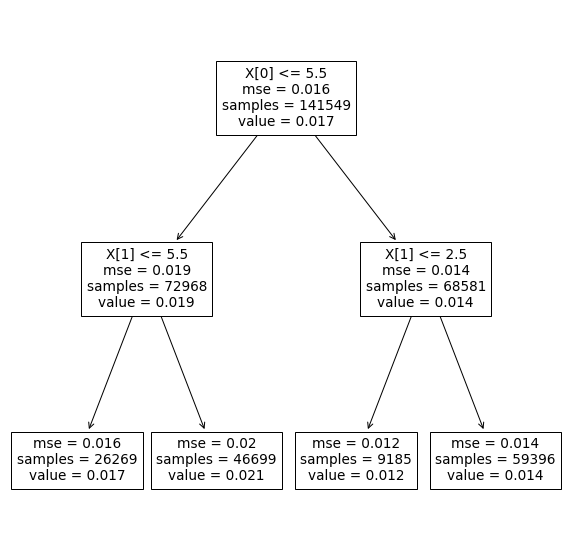

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

plot_tree(tree, ax=ax)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

#X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
#looks like X needs to be ints
X = final_df[['CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'CRASH_HOUR', 'LANE_CNT']]
y = final_df['INJURY_CLASSIFICATION'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [33]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
from scipy import stats

In [ ]:
final_df.corr()